<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель <br>Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Домашнее задание № 10
## <center> Реализация градиентного бустинга

В этом задании мы реализуем алгоритм градиентного бустинга в довольно общем виде, один и тот же класс будет описывать бинарный классификатор, при обучении которого минимизируется логистическая фунцкция потерь, и 2 регрессора, минимизирующих среднеквадратическую ошибку MSE и [RMSLE](https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError). Это даст представление о том, что с помощью градиентного бустинга можно оптимизировать произвольные дифференцируемые функции потерь, а также что бустинг адаптируется под разные задачи. [Веб-форма](https://goo.gl/forms/mMUhGSDiOHJI9NHN2) для ответов.

Версию алгоритма берем из [статьи](https://habrahabr.ru/company/ods/blog/327250/#klassicheskiy-gbm-algoritm-friedman-a) (см. псевдокод), но с двумя упрощениями:
- инициализация – средним значением вектора $\large y$, то есть $\large \hat{f_0} = \frac{1}{n}\sum_{i=1}^{n}y_i$
- шаг градиентного спуска (то же что и вес очередного базового алгоритма в композиции) постоянный: $\large \rho_t = const$

Соответствие обозначений в псевдокоде и в классе `GradientBoosting`, который мы сейчас напишем:
- $\large \{x_i, y_i\}_{i = 1,\ldots n}$ или `X`, `y` – обучающая выборка
- $\large L(y,f)$ или `objective` – функция потерь
- $\large \frac{\partial L(y_i,f(x_i))}{\partial f(x_i)}$ или `objective_grad` – градиент функции потерь
- $М$ или `n_estimators` – число итераций бустинга
- $\large h(x,\theta)$ или `DecisionionTreeRegressor` – базовый алгоритм, дерево решений для регрессии
- $\large \theta$ – гиперпараметры деревьев, мы рассмотрим только `max_depth` и `random_state`
- $\large \rho_t$ или `learning_rate` – коэффициент, с которым  $\large h_t(x,\theta)$ входит в композицию, $t=1,\ldots,M$

## Вычисление градиентов log_loss, MSE и RMSLE

Для начала классика – возьмем ручку и бумажку и посчитаем градиенты функций потерь:

$$log\_loss(y, p) = -y\log p - (1 - y)\log (1 - p) = -\sum_{i=1}^{n}y_i\log p_i + (1 - y_i)\log (1 - p_i)$$

$$MSE(y, p) = \frac{1}{n}(y - p)^T(y - p) = \frac{1}{n}\sum_{i=1}^{n}(y_i - p_i)^2$$

$$RMSLE(y, p) = \sqrt{\frac{1}{n} (\log (p + 1) - \log (y + 1))^T(\log (p + 1) - \log (y + 1))} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}(\log (p_i + 1) - \log (y_i + 1))^2}$$

Здесь $y$ и $p$ – это **векторы** истинных ответов и прогнозов соответственно.
`log_loss` взяли как в  `sklearn` – для случая меток целевого класса 0 и 1, а не -1 и 1, как описано в статье (только не усреднили, т.е. нет деления на число объектов $n$, в `sklearn` это соответствует значению аргумента `normalize=False` функции `log_loss`).

<font color='red'>Вопрос 1.</font> Какова формула градиента функции `MSE`?
 1. $(p - y) \hspace{5cm}$ 3. $2(p - y)$
 <br><br>
 2. $\frac{2}{n}(y - p) \hspace{4.7cm}$ 4. $\frac{2}{n}(p - y)$
 
 

<font color='red'>Вопрос 2.</font> Какова формула градиента функции `log_loss`?
 1. $\large \frac{y - p}{y(1 - y)} \hspace{5.2cm}$ 3. $\large \frac{p - y}{p(1 - p)}$
 <br><br>
 2. $\large \frac{y - p}{p(1 - p)}\hspace{5.2cm}$ 4. $\large \frac{p - y}{y(1 - y)}$
 <br><br>
 *Примечание:* деление на вектор – покомпонентное, например $\frac{1}{p} = (\frac{1}{p_1}, \ldots \frac{1}{p_n})^T$

<font color='red'>Вопрос 3.</font> Какова формула градиента функции `RMSLE`?
 1. $\frac{1}{n} (p + 1) RMSLE^{-1}(y, p) \log \frac{p+1}{y+1} \hspace{5cm}$ 3. $[n (y + 1) RMSLE(y, p)]^{-1} \log \frac{p+1}{y+1} $
 <br><br>
 2. $[n (p + 1) RMSLE(y, p)]^{-1} \log \frac{p+1}{y+1} \hspace{5cm}$ 4. $\frac{1}{n} \frac{y+1}{(p + 1)} RMSLE^{-1}(y, p) \log \frac{p+1}{y+1}$

## Реализация алгоритма

Напишем класс `GradientBoosting`. Детали:
- класс наследуется от `sklearn.base.BaseEstimator`;
- конструктор принимает параметры `loss` – название фунцкии потерь, которая будет оптимизироваться (`log_loss`, `mse` (по умолчанию) или `rmsle`), `n_estimators` – число деревьев (т.е. число итераций бустинга, по умолчанию – 10), `learning_rate` – шаг градиентного спуска (по умолчанию $10^{-2}$), `max_depth` – ограничение на максимальную глубину деревьев (по умолчанию 3) и `random_state` – сид генерации псевдослучайных чисел, нужен только для деревьев (по умолчанию 17);
- в зависимости от переданного значения `loss` инициализируются `objective` и `objective_grad`. Для `MSE` берем `sklearn.metrics.mean_squared_error`, для `log_loss` – `sklearn.metrics.log_loss` (без нормализации, то есть на число объектов не надо делить, формула дана выше), а `RMSLE` и градиенты всех трех функций надо реализовать самостоятельно. При подсчете градиентов не выкидывайте константы типа двойки или $n$;
- в реализациях градиентов `log_loss` и `rmsle` будет покомпонентное деление на вектора. Чтобы избежать деление на 0, предварительно замените значения, меньшие $10^{-5}$, на $10^{-5}$. Но только там, где необходимо. Например, в случае вычисления $\frac{y}{p}$ замены делаем только в векторе $p$;
- также в конструкторе создаются списки `loss_by_iter_` и `residuals_by_iter_` для отлаживания работы алгоритма и `trees_` – для хранения обученных деревьев;
- класс имеет методы `fit`, `predict` и `predict_proba`
- метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), а возвращает текущий экземпляр класса `GradientBoosting`, т.е. `self`. Основная логика, конечно же, реализуется здесь. На каждой итерации текущее значение функции потерь записывается в `loss_by_iter_`, значение антиградиента (то что в статье названо псевдо-остатками) – в `residuals_by_iter_` (можно в конструктор добавить флаг `debug=False` и добавлять значения антиградиента только при включенном флаге). Также обученное дерево добавляется в список `trees_`;
- метод `predict_proba` возвращает линейную комбинацию прогнозов деревьев. Не забудем тут и про начальное приближение. В случае регрессии название метода будет не очень удачным, но оставим так, чтоб не писать отдельно классификатор и регрессор. В случае классификации к ответу применяется $\sigma$-преобразование. В реализации $\sigma$-функции замените значения аргумента, превышающие по модулю 100, на -100 или +100 в зависимости от знака (чтоб избежать underflow & overflow);
- метод `predict` в случае регрессии возвращает линейную комбинацию прогнозов деревьев (+ начальное приближение), то есть то же, что и `predict_proba`. В случае классификации метод `predict` задействует метод `predict_proba` и возвращает вектор из 0 и 1, полученный сравнением предсказанных вероятностей с некоторым порогом, при котором максимизируется доля правильных ответов на обучающей выборке. Здесь хорошо было бы решить одномерную задачу оптимизации, но для полной воспроизводимости давайте выбирать порог из `np.linspace(0.01, 1.01, 100)`.


In [490]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

In [445]:
class GradientBoosting(BaseEstimator):
    
    def sigma(self, z):
        z[np.where(z > 100)] = 100
        z[np.where(z < -100)] = -100
            
        return np.array([1 / (1 + np.exp(-x)) for x in z])
    
    def log_loss_unnormalized(self, y, p):
        return log_loss(y, p, normalize=False)
    
    def log_loss_grad(self, y, p):
        denom = p * (1 - p)
        denom[denom < 1e-5] = 1e-5
        return (p - y) / denom
    
    def mse_grad(self, y, p):
        return 2 / y.shape[0] * (p - y)
    
    def rmsle(self, y, p):
        return np.sqrt(1 / y.shape[0] * np.sum(np.square(np.log(p + 1) - np.log(y + 1))))
    
    def rmsle_grad(self, y, p):
        denom = y.shape[0] * (p + 1) * self.rmsle(y, p)
        denom[denom < 1e-5] = 1e-5
        return 1 / denom * (np.log(p + 1) - np.log(y + 1))
    
    def __init__(self, loss='mse', n_estimators=10, learning_rate=1e-2, max_depth=3, random_state=17):

        if loss == 'mse':
            self.objective = mean_squared_error
            self.objective_grad = self.mse_grad
            self.classification = False
        elif loss == 'log_loss':
            self.objective = self.log_loss_unnormalized
            self.objective_grad = self.log_loss_grad
            self.classification = True
        elif loss == 'rmsle': 
            self.objective = self.rmsle
            self.objective_grad = self.rmsle_grad
            self.classification = False
        else: 
            raise Exception('invalid loss function')
        
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        
        self.loss_by_iter_ = []
        self.residuals_by_iter_ = [] 
        self.trees_ = []
    
    def fit(self, X, y):
        self.initial_approximation = np.mean(y)
        for i in range(self.n_estimators):
            predictions = self._piecewise_function(X, i - 1)
            residuals_by_iter = -self.objective_grad(y, predictions)
            self.residuals_by_iter_.append(residuals_by_iter)
            
            h = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            h.fit(X, residuals_by_iter)
            self.trees_.append(h)
            
            loss_by_iter = self.objective(y, (predictions.T + self.learning_rate * h.predict(X)).T)
            self.loss_by_iter_.append(loss_by_iter)
            
        if self.classification:
            self._select_threshold(X, y)
        
        return self
    
    def _piecewise_function(self, X, t):
        result = np.array([self.initial_approximation * np.ones(X.shape[0])])
        for j in range(t):
            result = result + self.learning_rate * self.trees_[j].predict(X)

        return self.sigma(result).T if self.classification else result.T
    
    def _select_threshold(self, X, y):
        probabilities = self.predict_proba(X)
        
        precisions = []
        lspace = np.linspace(0.01, 1.01, 100)
        for threshold in lspace:
            proba_copy = np.array(probabilities, copy=True)
            proba_copy[np.where(proba_copy <= threshold)] = 0
            proba_copy[np.where(proba_copy > threshold)] = 1
            
            precision = (y.shape[0] - np.sum(np.abs(proba_copy - y))) / float(y.shape[0])
            precisions.append(precision)
            
        self.threshold = lspace[np.argmax(np.array(precisions))]
        print(self.threshold)
    
    def predict_proba(self, X):
        return self._piecewise_function(X, len(self.trees_))

    def predict(self, X):
        proba = self.predict_proba(X)            
        if self.classification:
            proba[np.where(proba <= self.threshold)] = 0
            proba[np.where(proba > self.threshold)] = 1

        return proba

## Регрессия с игрушечным примером

In [242]:
X_regr_toy = np.arange(7).reshape(-1, 1)
y_regr_toy = ((X_regr_toy - 3) ** 2).astype('float64')

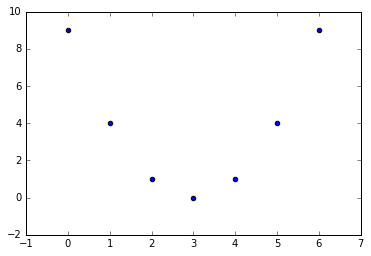

In [377]:
plt.scatter(X_regr_toy, y_regr_toy)

Обучите регрессор `GradientBoosting` с функцией потерь `MSE` и параметрами `learning_rate`=0.1,  `max_depth`=3 – 200 итераций. Посмотрите на изменение функции потерь по итерациям бустинга. Можно также посмотреть на приближение и остатки на первых нескольких итерациях, как это делалось в статье.

In [446]:
gbm = GradientBoosting(loss='mse', n_estimators=200, learning_rate=0.1, max_depth=3)
gbm.fit(X_regr_toy, y_regr_toy)

GradientBoosting(learning_rate=0.1, loss=None, max_depth=3, n_estimators=200,
         random_state=17)

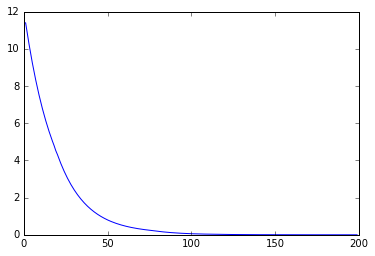

In [447]:
plt.plot(gbm.loss_by_iter_)

In [448]:
for residuals in gbm.residuals_by_iter_[20:40]:
    print (np.array(residuals).T)

[[ 0.81048288  0.13121953 -0.5377867  -0.82350099 -0.5377867   0.1468891
   0.81048288]]
[[ 0.78662387  0.12735713 -0.51932078 -0.80503507 -0.51932078  0.14307177
   0.78662387]]
[[ 0.76346721  0.123608   -0.50123436 -0.78694865 -0.50123436  0.13887494
   0.76346721]]
[[ 0.74099224  0.11996923 -0.48367553 -0.76938982 -0.48367553  0.13478717
   0.74099224]]
[[ 0.7191789   0.11643757 -0.46663346 -0.75234775 -0.46663346  0.13081932
   0.7191789 ]]
[[ 0.69800769  0.11300988 -0.45009307 -0.73580736 -0.45009307  0.12696826
   0.69800769]]
[[ 0.67745972  0.10968309 -0.4340396  -0.71975389 -0.4340396   0.12323056
   0.67745972]]
[[ 0.65751664  0.10645424 -0.41845871 -0.704173   -0.41845871  0.1196029
   0.65751664]]
[[ 0.63816065  0.10332043 -0.40333649 -0.68905078 -0.40333649  0.11608202
   0.63816065]]
[[ 0.61937446  0.10027888 -0.38865944 -0.67437373 -0.38865944  0.1126648
   0.61937446]]
[[ 0.6011413   0.09732687 -0.37441445 -0.66012874 -0.37441445  0.10934817
   0.6011413 ]]
[[ 0.58344489

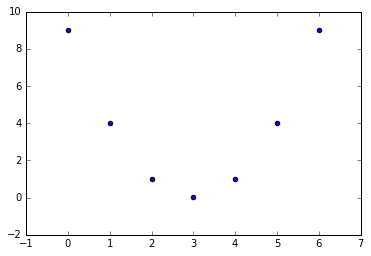

In [449]:
plt.scatter(X_regr_toy, gbm.predict(X_regr_toy))

Обучите регрессор `GradientBoosting` с теми же параметрами, но функцию потерь измените на `RMSLE`. Посмотрите на те же картинки. 

In [450]:
gbm = GradientBoosting(loss='rmsle', n_estimators=200, learning_rate=0.1, max_depth=3)
gbm.fit(X_regr_toy, y_regr_toy)

GradientBoosting(learning_rate=0.1, loss=None, max_depth=3, n_estimators=200,
         random_state=17)

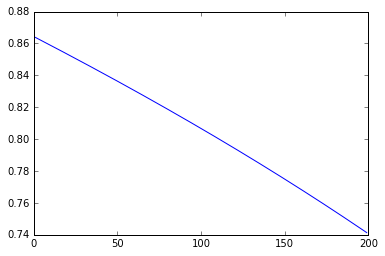

In [451]:
plt.plot(gbm.loss_by_iter_)

In [452]:
for residuals in gbm.residuals_by_iter_[0:20]:
    print (np.array(residuals).T)

[[ 0.02291079 -0.         -0.03028642 -0.05319721 -0.03028642 -0.
   0.02291079]]
[[ 0.02291079 -0.         -0.03028642 -0.05319721 -0.03028642 -0.
   0.02291079]]
[[ 0.02289961 -0.         -0.03030385 -0.05324762 -0.03030321 -0.
   0.02289961]]
[[ 0.02288845 -0.         -0.0303213  -0.05329812 -0.03032001 -0.
   0.02288845]]
[[ 0.02287734 -0.         -0.03033813 -0.05334873 -0.03033748 -0.
   0.02287734]]
[[ 0.02286627 -0.         -0.03035497 -0.05339947 -0.03035497 -0.
   0.02286627]]
[[ 0.02285524 -0.         -0.03037182 -0.05345032 -0.03037249 -0.
   0.02285524]]
[[ 0.02284426 -0.         -0.03038936 -0.05350129 -0.03038936 -0.
   0.02284426]]
[[ 0.02283332 -0.         -0.03040693 -0.05355238 -0.03040624 -0.
   0.02283332]]
[[ 0.02282242 -0.         -0.03042453 -0.05360359 -0.03042314 -0.
   0.02282242]]
[[ 0.02281157 -0.         -0.03044145 -0.05365492 -0.03044075 -0.
   0.02281157]]
[[ 0.02280076 -0.         -0.03045838 -0.05370637 -0.03045839 -0.
   0.02280076]]
[[ 0.02279    -0

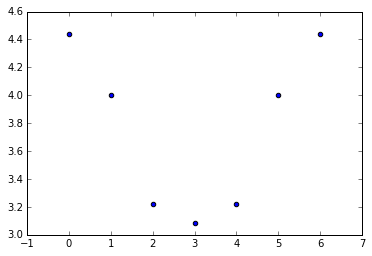

In [453]:
plt.scatter(X_regr_toy, gbm.predict(X_regr_toy))

## Классификация с игрушечным примером

In [454]:
X_clf_toy = np.c_[np.arange(7), (np.arange(7) - 3) ** 2]
y_clf_toy = np.array([0, 1, 0, 1, 0, 1, 0])

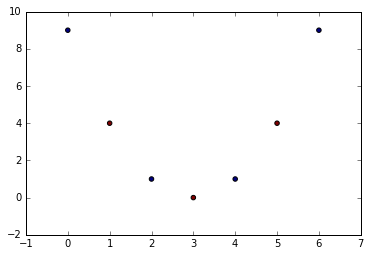

In [455]:
plt.scatter(X_clf_toy[:, 0], X_clf_toy[:, 1], c=y_clf_toy);

In [506]:
gbm = GradientBoosting(loss='log_loss', n_estimators=10, learning_rate=0.05, max_depth=3)
gbm.fit(X_clf_toy, np.array([y_clf_toy]).T)

0.363535353535


GradientBoosting(learning_rate=0.05, loss=None, max_depth=3, n_estimators=10,
         random_state=17)

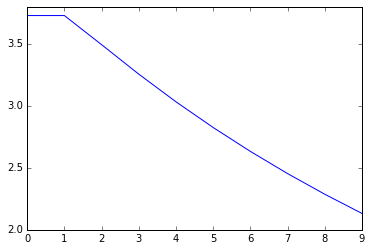

In [507]:
plt.plot(gbm.loss_by_iter_)

In [508]:
for residuals in gbm.residuals_by_iter_:
    print (np.array(residuals).T)

[[-2.53506301  1.65143906 -2.53506301  1.65143906 -2.53506301  1.65143906
  -2.53506301]]
[[-2.53506301  1.65143906 -2.53506301  1.65143906 -2.53506301  1.65143906
  -2.53506301]]
[[-2.35231546  1.59980938 -2.35231546  1.59980938 -2.35231546  1.59980938
  -2.35231546]]
[[-2.1913238   1.55227159 -2.1913238   1.55227159 -2.1913238   1.55227159
  -2.1913238 ]]
[[-2.05913163  1.5098158  -2.05913163  1.5098158  -2.05913163  1.5098158
  -2.05913163]]
[[-1.94921796  1.47174373 -1.94921796  1.47174373 -1.94921796  1.47174373
  -1.94921796]]
[[-1.8563523   1.43744243 -1.8563523   1.43744243 -1.8563523   1.43744243
  -1.8563523 ]]
[[-1.77682956  1.40640814 -1.77682956  1.40640814 -1.77682956  1.40640814
  -1.77682956]]
[[-1.70797115  1.37822369 -1.70797115  1.37822369 -1.70797115  1.37822369
  -1.70797115]]
[[-1.64778696  1.35254046 -1.64778696  1.35254046 -1.64778696  1.35254046
  -1.64778696]]


In [509]:
gbm.predict(X_clf_toy)

array([[ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.]])

In [510]:
gbm.predict_proba(X_clf_toy)

array([[ 0.35389053],
       [ 0.764791  ],
       [ 0.35389053],
       [ 0.764791  ],
       [ 0.35389053],
       [ 0.764791  ],
       [ 0.35389053]])

Обучите классификатор `GradientBoosting` с функцией потерь `log_loss` и параметрами `learning_rate`=0.05,  `max_depth`=3 – 10 итераций. Посмотрите на изменение функции потерь по итерациям бустинга. Можно также посмотреть на приближение и остатки на первых нескольких итерациях, как это делалось в статье.



<font color='red'>Вопрос 4.</font> Посчитайте предсказанные вероятности отнесения к классу +1 для всех 7 объектов игрушечной выборки. Каковы 2 уникальных значения в полученном векторе?
1. 0.42 и 0.77
2. 0.36 и 0.82
3. 0.48 и 0.53
4. 0.46 и 0.75

## Регрессия с UCI boston

In [461]:
boston = load_boston()
X, y = boston.data, boston.target

In [462]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

- Обучите регрессор `GradientBoosting` с функцией потерь `MSE` и параметрами `learning_rate`=3,  `max_depth`=10 – 300 итераций
- Посмотрите на изменение функции потерь по итерациям бустинга
- Сделайте прогнозы для отложенной выборки
- Постройте распределение ответов `y_test` на отложенной выборке и наложите на него распределение ответов бустинга `test_pred`. Используйте метод `hist` из `matplotlib.pyplot` с параметром `bins=15`

<font color='red'>Вопрос 5.</font> Выберите верное утверждение про гистограммы:
1. Ответы бустинга в среднем завышены на 10 
2. **В бине, в который попадает медиана ответов на тестовой выборке (`numpy.median(y_test)`), больше значений из вектора прогнозов `test_pred`, чем из вектора ответов `y_test`**
3. **Бустинг иногда прогнозирует значения, сильно выпадающие за диапазон изменения ответов `y_test`**

In [463]:
gbm = GradientBoosting(loss='mse', n_estimators=300, learning_rate=0.3, max_depth=10)
gbm.fit(X_train, np.array([y_train]).T)

GradientBoosting(learning_rate=0.3, loss=None, max_depth=10, n_estimators=300,
         random_state=17)

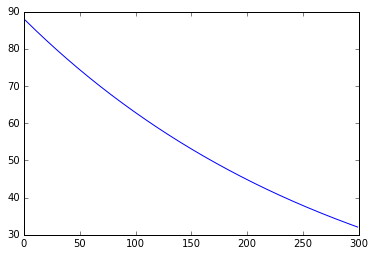

In [464]:
plt.plot(gbm.loss_by_iter_)

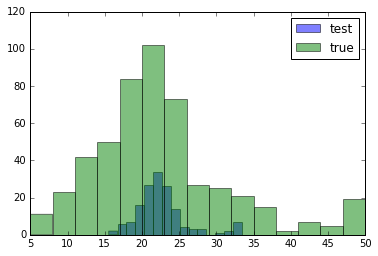

21.3


In [480]:
predictions = gbm.predict(X_test)
pyplot.hist(predictions, bins=15, label="test", alpha=0.5)
pyplot.hist(y, bins=15, label="true", alpha=0.5)
pyplot.legend(loc='upper right')
pyplot.show()
print (np.median(y_test))

## Классификация с UCI breast cancer

In [481]:
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

In [482]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

Обучите классификатор `GradientBoosting` с функцией потерь `log_loss` и параметрами `learning_rate`=0.01,  `max_depth`=3 – 200 итераций. Посмотрите на изменение функции потерь по итерациям бустинга. Сделайте прогнозы для отложенной выборки – как предсказанные вероятности отнесения к классу +1, так и бинарные прогнозы. Посчитайте ROC AUC для прогноза в виде вероятностей и долю правильных ответов для прогноза в виде меток классов.

<font color='red'>Вопрос 6.</font> Каковы получаются ROC AUC и доля правильных ответов на отложенной выборке `(X_test, y_test)`?
1. 0.99 и 0.97
2. 1 и 0.97
3. **0.98 и 0.96**
4. 0.97 и 0.95

In [483]:
gbm = GradientBoosting(loss='log_loss', n_estimators=200, learning_rate=0.01, max_depth=3)
gbm.fit(X_train, np.array([y_train]).T)

0.494848484848


GradientBoosting(learning_rate=0.01, loss=None, max_depth=3, n_estimators=200,
         random_state=17)

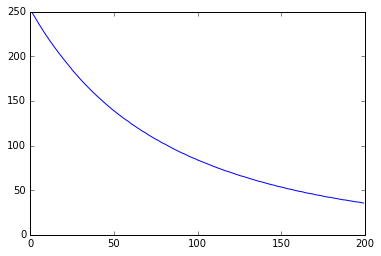

In [499]:
plt.plot(gbm.loss_by_iter_)

In [494]:
preds_proba = gbm.predict_proba(X_test)
preds = gbm.predict(X_test)

In [495]:
print (roc_auc_score(y_test, preds_proba))

0.988599105812


In [505]:
print ((y_test.shape[0] - np.sum(np.abs(preds.flatten() - y_test))) / float(y_test.shape[0]))

0.964912280702
